### Datasets used 

 #### ADAM_METADATA ADSL
 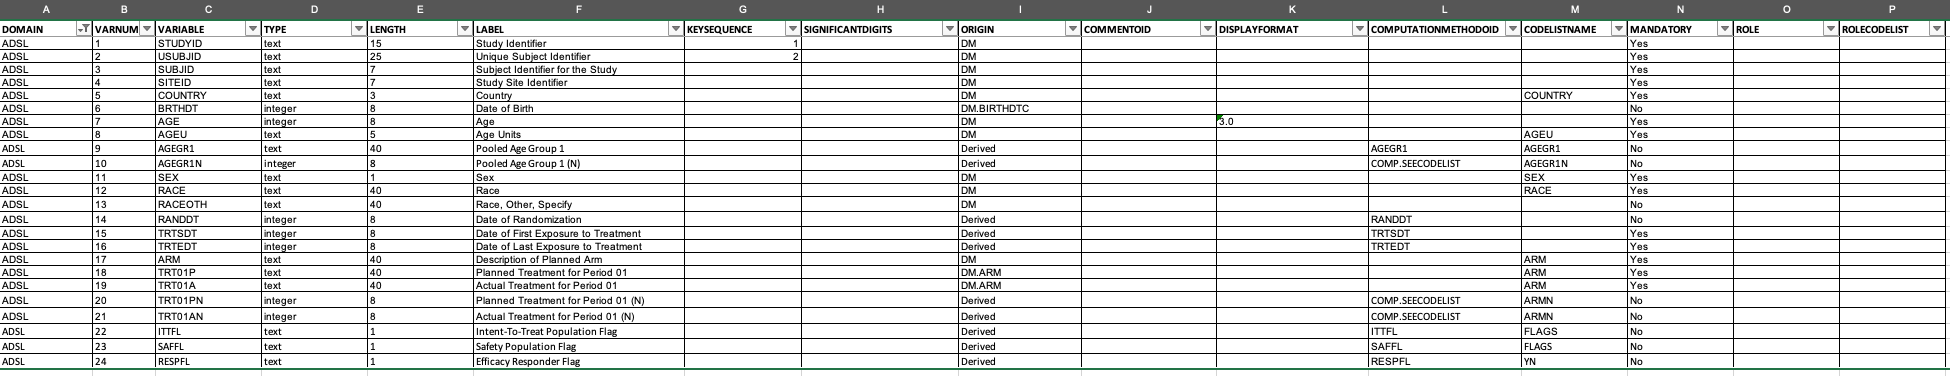

In [ ]:
%include "/home/junmeng0/02-Implementing CDISC Using SAS/chapter07/setup.sas";

**** CREATE EMPTY ADSL DATASET CALLED EMPTY_ADSL;

%let metadatafile=/home/junmeng0/02-Implementing CDISC Using SAS/chapter07/ADAM_METADATA.xls;
%make_empty_dataset(metadatafile=&metadatafile, dataset=ADSL) 


In [ ]:
** merge supplemental qualifiers into DM;
%mergsupp(sourcelib=sdtm, domains=DM); 

In [ ]:
/*------------------------------------------------------------;
 Merge supplemental qualifiers into the parent SDTM domain.
This can either be for an entire library or for specified domains;
*------------------------------------------------------------*/
%macro mergsupp(sourcelib=library, outlib=WORK, domains= , suppqual=0);
  %local domain;
    
  ** de-normalize suppqual and merge into the given domain;
  %macro domainx(domain= ,suppqual=0);
      %local suppdata idvar varlist nvars;
      
      %if &suppqual %then
        %let suppdata=suppqual;
      %else
        %let suppdata=supp&domain;
      ;
        
      * count the number of supplemental qualifiers for the given domain;
       proc sort 
        data = &sourcelib..&suppdata
        out = nvars
        nodupkey;  
          where rdomain=upcase("&domain");
          by qnam idvar;
      run;
            
      data _null_;
        set nvars end=eof;
          by qnam idvar;
             length varlist $200;	
             retain varlist;
             if not first.qnam then
                put 'PROB' 'LEM: More than one IDVAR for the domain-- ' 
                     rdomain= qnam=   
                              idvar= ;
             else
                do; 
                   nvars + 1; 
                   varlist = trim(varlist) || " " || trim(qnam);
                end;
             if eof then 
               do;
                  call symput("nvars", put(nvars, 2.)); 
                  call symput("varlist", trim(left(varlist)));
                  call symput("idvar", trim(idvar));
               end;  
      run;
      %put domain=&domain idvar=&idvar nvars=&nvars varlist=&varlist; 

      proc sort
        data = &sourcelib..&suppdata
        out = supp&domain;
          where rdomain=upcase("&domain");
          by usubjid idvar idvarval;
      run;

      %*  determine whether IDVAR in the parent domain is character or numeric; 
      %if &idvar^= %then
        %do;
          %let dsetnum=%sysfunc(open(&sourcelib..&domain));
          %let varnum=%sysfunc(varnum(&dsetnum,&idvar));
          %let idtype=%sysfunc(vartype(&dsetnum,&varnum));
          %let rc=%sysfunc(close(&dsetnum));
        %end;
      %else
        %let idtype= ;

      data supp&domain;
        set supp&domain;
          by usubjid idvar idvarval;
             drop q: idvarval idvar i rdomain;
             length &varlist $200.;
             retain &varlist;
             array vars{*} &varlist;
             if first.idvarval then
               do i = 1 to dim(vars); 
                 vars{i} = '';
               end;
             do i = 1 to dim(vars);
               if upcase(qnam)=upcase(vname(vars{i})) then
                 vars{i} = qval;
             end;

             %** convert to numeric if numeric in the parent domain; 
             %if &idvar^= and &idtype=N %then
                &idvar = input(idvarval, best.);
             %else %if &idvar^= %then
               &idvar = idvarval;
             ;
             if last.idvarval;
      run;
      proc sort
        data = supp&domain;
          by usubjid &idvar;
      proc sort
        data = &sourcelib..&domain
        out = __tmp;
          by usubjid &idvar;
      data &outlib..&domain;
        merge __tmp supp&domain ; 
          by usubjid &idvar;
      run;
    %mend domainx;
    
    /*-------------------------------------------------------;
    % If DOMAINS parameter specified, then loop through those 
    %* domains;
    %* otherwise, dynamically identify the SUPPxx data sets and 
    %* go through them all;
    %*-------------------------------------------------------;*/
    %let _wrd=1;
    %if &DOMAINS^= %then 
      %do %while(%scan(&domains,&_wrd)^= );                
          %let domain=%scan(&domains,&_wrd);
          %domainx(domain=&domain,suppqual=0);
          %let _wrd=%eval(&_wrd+1);
      %end;
    %else
      %do;                
          ** find all of the SUPPxx datasets and loop through each one;
          ods output members=members;
          proc contents
            data = &sourcelib.._all_ memtype=data nods ;
          run;
         data members;
            set members;
             if upcase(name)=:'SUPP' and upcase(name)^=:'SUPPQUAL' then
                      do;
                      rdomain = substr(name,5,2);
                      put name= rdomain= ;
 
                     output;
                   end;
                 else if upcase(name)=:'SUPPQUAL' then
                   call symput("suppqual","1");
          run;
    
          %** loop through each domain;
          proc sql noprint;
           select count(distinct rdomain)
             into :domn
             from %if &suppqual %then &sourcelib..suppqual; %else 
                members;
             ;   
           select distinct rdomain 
             into :domain1 - :domain%left(&domn)
             from %if &suppqual %then &sourcelib..suppqual; %else 
                members;
             ;
          %do _i=1 %to &domn;
            %domainx(domain=&&domain&_i,suppqual=&suppqual);
          %end;
      %end; %* if domains not specified explicitly...;

%mend mergsupp;


In [ ]:
** find the change from baseline so that responders can be flagged ;
** (2-point improvement in pain at 6 months);
%cfb(indata=sdtm.xp, outdata=responders, dayvar=xpdy, avalvar= xpstresn, 
     keepvars=usubjid visitnum chg);

In [ ]:
data ADSL;
    merge EMPTY_ADSL
          	DM         (in = inDM) 
          	responders (in = inresp where=(visitnum=2))
          	;
      by usubjid;

        * convert RFXSTDTC to a numeric SAS date named TRTSDT;
        %dtc2dt(RFXSTDTC, prefix=TRTS );  

        * create BRTHDT, RANDDT, TRTEDT;
        %dtc2dt(BRTHDTC, prefix=BRTH);        
        %dtc2dt(RANDDTC, prefix=RAND);
        %dtc2dt(RFXENDTC, prefix=TRTE);

        * created flags for ITT and safety-evaluable;
        ittfl = put(randdt, popfl.);
        saffl = put(trtsdt, popfl.);

        trt01p = ARM;
        trt01a = trt01p;
        trt01pn = input(put(trt01p, $trt01pn.), best.);
        trt01an = trt01pn;                 
        agegr1n = input(put(age, agegr1n.), best.);
        agegr1  = put(agegr1n, agegr1_.);
        RESPFL = put((.z <= chg <= -2), _0n1y.);         
run;

In [ ]:
**** SORT ADSL ACCORDING TO METADATA AND SAVE PERMANENT DATASET;  
%make_sort_order(metadatafile=&metadatafile, dataset=ADSL)

proc sort
  data=adsl
  (keep = &ADSLKEEPSTRING)
  out=adam.adsl;
    by &ADSLSORTSTRING;
run;